<a href="https://colab.research.google.com/github/PLONTZNathan/MachineLearning_Assignment1/blob/elena/TASK4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [3]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/X_train.csv'
train = pd.read_csv(file_path)
file_path_2 = '/content/drive/MyDrive/X_test.csv'
test = pd.read_csv(file_path_2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**DATA CLEANED**

In [4]:
def check_trajectories_start_zero(df, traj_len=257):
    num_traj = len(df) // traj_len
    zero_traj = []

    for i in range(num_traj):
        start_idx = i * traj_len
        first_row = df.iloc[start_idx]

        # Controlla se tutti i valori della prima riga sono zero
        if (first_row == 0).all():
            zero_traj.append(i)

    return zero_traj

In [5]:
train_no_id = train.iloc[:, :-1]
traj_zero=check_trajectories_start_zero(train_no_id,257)

In [6]:
def remove_zero_trajectories(df, zero_traj, traj_len=257):
    drop_indices = []

    for traj_id in zero_traj:
        start = traj_id * traj_len
        end = (traj_id + 1) * traj_len
        drop_indices.extend(range(start, end))

    df_cleaned = df.drop(drop_indices).reset_index(drop=True)
    return df_cleaned

In [7]:
train_cleaned = remove_zero_trajectories(train, traj_zero, 257)

In [8]:
def remove_collision(df, traj_len=257, tol=1e-8):

    cleaned = []
    num_traj = len(df) // traj_len

    for i in range(num_traj):
        start = i * traj_len
        end = (i + 1) * traj_len
        traj = df.iloc[start:end]

        traj_features = traj.iloc[:, :-1]

        zero_mask = (np.abs(traj_features.values) < tol).all(axis=1)

        if zero_mask.any():
            first_zero = zero_mask.argmax() + start
            traj = traj.loc[start:first_zero-1]

        cleaned.append(traj)

    cleaned_df = pd.concat(cleaned).reset_index(drop=True)
    return cleaned_df

In [9]:
train_cleaned = remove_collision(train_cleaned)

SPLIT DATASET

In [10]:
def split_trajectories(df,
                                train_size=0.6,
                                validation_size=0.2,
                                test_size=0.2,
                                method="random",
                                random_state=None):

    if random_state is not None:
        np.random.seed(random_state)

    # Identifier les indices de début de trajectoire
    traj_start_indices = df.index[df['t'] == 0].tolist()
    traj_start_indices.append(len(df))  # ajouter la fin pour le dernier bloc

    # Construire les slices de trajectoires
    traj_slices = [(traj_start_indices[i], traj_start_indices[i+1]) for i in range(len(traj_start_indices)-1)]

    if method == "random":
        np.random.shuffle(traj_slices)
    else:
        raise NotImplementedError(f"Méthode {method} non implémentée pour l'instant")

    n_traj = len(traj_slices)
    n_train = int(train_size * n_traj)
    n_val = int(validation_size * n_traj)
    n_test = int(test_size * n_traj)

    # Ajustement si reste
    n_remaining = n_traj - (n_train + n_val + n_test)
    n_train += n_remaining

    train_slices = traj_slices[:n_train]
    val_slices = traj_slices[n_train:n_train+n_val]
    test_slices = traj_slices[n_train+n_val:n_train+n_val+n_test]

    # Concaténer les DataFrames correspondants
    train_df = pd.concat([df.iloc[start:end] for start, end in train_slices]).reset_index(drop=True)
    val_df = pd.concat([df.iloc[start:end] for start, end in val_slices]).reset_index(drop=True)
    test_df = pd.concat([df.iloc[start:end] for start, end in test_slices]).reset_index(drop=True)

    return train_df, val_df, test_df

In [11]:
train_after_split, validation_after_split, test_after_split = split_trajectories(train_cleaned)

In [12]:
def replicate_initial_position_by_block(df):
    coords = ["x_1", "y_1",
              "x_2", "y_2",
              "x_3", "y_3"]

    copy = df.copy()
    data = copy[coords].values
    t_values = copy["t"].values

    # Détecter le début des blocs
    block_starts = np.where(t_values == 0)[0]
    block_starts = np.append(block_starts, len(df))  # ajouter fin du dernier bloc

    # Répliquer la position initiale pour chaque bloc
    for i in range(len(block_starts) - 1):
        start, end = block_starts[i], block_starts[i + 1]
        data[start:end] = data[start]  # réplication vectorisée


    copy[coords] = data
    return copy

In [13]:
train_entry=replicate_initial_position_by_block(train_after_split)
validation_entry=replicate_initial_position_by_block(validation_after_split)
test_entry=replicate_initial_position_by_block(test_after_split)

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

input_cols = ['t', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
target_cols = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']

X_train = train_entry[input_cols]
y_train = train_after_split[target_cols]

pipeline.fit(X_train, y_train)

,steps,"[('standardscaler', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [15]:
X_val = validation_entry[input_cols]
y_val = validation_after_split[target_cols]

y_pred_val = pipeline.predict(X_val)

X_test = test_entry[input_cols]
y_test= test_after_split[target_cols]

y_pred_test = pipeline.predict(X_test)

**KNN**

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import time

In [19]:
def validate_knn_regression(X_train, y_train, X_val, y_val, k=range(1,15)):

    results = []

    for n in k:
        start_train = time.time()
        model = KNeighborsRegressor(n_neighbors=n)
        model.fit(X_train, y_train)
        end_train = time.time()
        train_time = end_train - start_train

        start_pred = time.time()
        y_pred = model.predict(X_val)
        end_pred = time.time()
        inference_time = end_pred - start_pred

        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        results.append([n, train_time, inference_time, rmse])
        print(f"k={n:2d} | RMSE={rmse:.4f} | Train={train_time:.4f}s | Predict={inference_time:.4f}s")

    results_df = pd.DataFrame(results, columns=["k", "train_time", "inference_time", "RMSE"])

    # Plot RMSE vs k
    plt.figure(figsize=(8,5))
    plt.plot(results_df["k"], results_df["RMSE"], marker='o', label="Validation RMSE")
    plt.title("kNN Regression – Validation RMSE vs k")
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("RMSE")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot training/inference times
    plt.figure(figsize=(8,5))
    plt.plot(results_df["k"], results_df["train_time"], marker='o', label="Training time (s)")
    plt.plot(results_df["k"], results_df["inference_time"], marker='o', label="Inference time (s)")
    plt.title("kNN – Computational Cost vs k")
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("Time (seconds)")
    plt.grid(True)
    plt.legend()
    plt.show()

    return results_df



k= 1 | RMSE=1.3978 | Train=1.3308s | Predict=1.3723s
k= 2 | RMSE=1.2417 | Train=1.3309s | Predict=1.5491s
k= 3 | RMSE=1.2317 | Train=1.2962s | Predict=1.8626s
k= 4 | RMSE=1.2158 | Train=2.0167s | Predict=2.3054s
k= 5 | RMSE=1.2152 | Train=1.3373s | Predict=1.9412s
k= 6 | RMSE=1.2217 | Train=1.3197s | Predict=2.1032s
k= 7 | RMSE=1.2190 | Train=1.3004s | Predict=2.9844s
k= 8 | RMSE=1.2244 | Train=1.8220s | Predict=2.3181s
k= 9 | RMSE=1.2287 | Train=1.3060s | Predict=2.4333s
k=10 | RMSE=1.2375 | Train=1.3111s | Predict=2.7509s
k=11 | RMSE=1.2359 | Train=1.9963s | Predict=3.1190s
k=12 | RMSE=1.2365 | Train=1.3276s | Predict=2.8507s
k=13 | RMSE=1.2388 | Train=1.2826s | Predict=3.2677s
k=14 | RMSE=1.2407 | Train=2.0755s | Predict=3.3692s


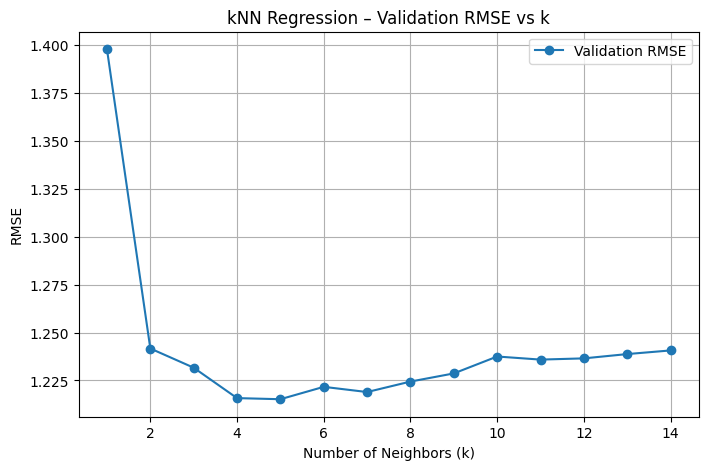

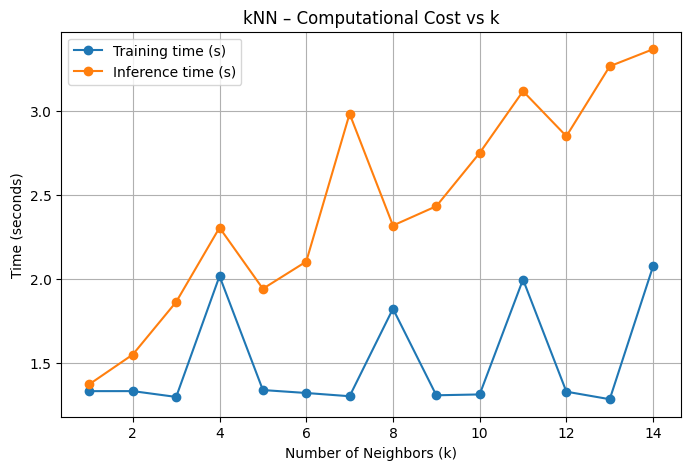

In [20]:
results_df = validate_knn_regression(X_train, y_train, X_val, y_val, k=range(1, 15))


Best k found: 5


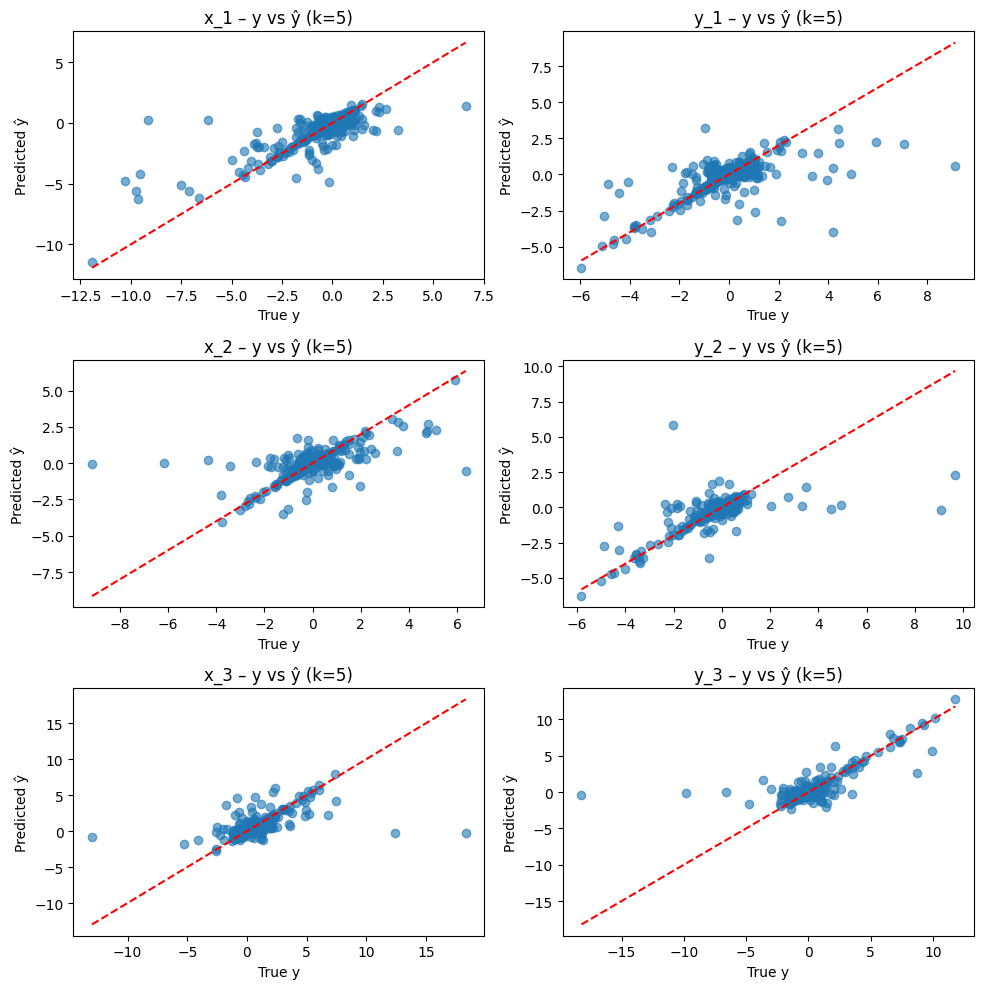

In [23]:
# Evaluate best k and plot y vs y_hat
best_k = results_df.loc[results_df["RMSE"].idxmin(), "k"]
print(f"\nBest k found: {best_k}")

best_model = KNeighborsRegressor(n_neighbors=int(best_k))
best_model.fit(X_train, y_train)
y_pred_val = best_model.predict(X_val)

# y vs y_hat plots for each output (if multi-output)
labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
MAX = 500
y_val_np = np.array(y_val)
y_pred_val_np = np.array(y_pred_val)

if len(y_val_np) > MAX:
    idx = np.random.choice(len(y_val_np), MAX, replace=False)
else:
    idx = np.arange(len(y_val_np))

plt.figure(figsize=(10,10))
for i in range(y_val_np.shape[1]):
    plt.subplot(3,2,i+1)
    plt.scatter(y_val_np[idx,i], y_pred_val_np[idx,i], alpha=0.6)
    plt.plot([y_val_np[idx,i].min(), y_val_np[idx,i].max()],
             [y_val_np[idx,i].min(), y_val_np[idx,i].max()], 'r--')
    plt.title(f"{labels[i]} – y vs ŷ (k={best_k})")
    plt.xlabel("True y"); plt.ylabel("Predicted ŷ")
plt.tight_layout()
plt.show()

In [ ]:
#comparison linear vs polynomial vs knn